# SMS Spam Detection using Deep Learning

Repo: https://github.com/MFranco2000/supreme-octo-spoon

**I. Introduction**

**Problem Definition:**
The spam detection problem, in the context of SMS messages, is a binary text classification task. The goal is to automatically categorize incoming SMS messages into one of two classes: 'spam' (unsolicited or unwanted messages, often for advertising or malicious purposes) or 'ham' (legitimate, non-spam messages). This classification is crucial for filtering out unwanted content and improving the user experience by preventing distractions and potential security threats.

**Dataset:**
The SMS Spam Collection dataset is a publicly available dataset from the UCI Machine Learning Repository. It contains a collection of SMS tagged messages in English. The dataset consists of one file containing a set of SMS messages labeled according to whether they are ham or spam.

**Justification for Deep Learning:**
Deep learning models have shown remarkable success in various natural language processing (NLP) tasks, including text classification. Their ability to automatically learn complex patterns and hierarchical representations from raw text data makes them good for spam detection. Traditional machine learning approaches often rely on handcrafted features (like word frequencies, presence of certain keywords), which can be time-consuming and may not capture the nuanced characteristics of spam messages. Deep learning models, particularly Recurrent Neural Networks (RNNs) and their variants like LSTMs, can effectively model sequential dependencies in text, which is crucial for understanding the context and identifying cues indicative of spam. Furthermore, embedding layers in deep learning can learn dense vector representations of words, capturing semantic relationships that are often missed by simpler methods.

**II. Data Gathering and Provenance**

**Data Source:**
The data source is the UCI Machine Learning Repository, accessible via the following URL: [https://archive.ics.uci.edu/datasets/SMS+Spam+Collection](https://archive.ics.uci.edu/datasets/SMS+Spam+Collection)

**Method of Data Collection:**
According to the dataset description on the UCI repository, the SMS Spam Collection is a public set of SMS labeled messages that have been collected for mobile phone spam research. It is composed of SMS messages drawn from grumbletext website of NUS (National University of Singapore) and a few SMS messages of well-known public available SMS corpus. These messages were manually tagged and then annotated with one of two classes: ham or spam.

**Data Provenance:**
The data originates from a reputable source (UCI Machine Learning Repository), which is known for hosting well-documented datasets used in machine learning research. The collection process involved gathering real-world SMS messages and manually labeling them, suggesting a degree of reliability in the ground truth. However, as with any real-world data, there might be potential biases or inconsistencies in the labeling process. The dataset has been widely used in the research community, indicating its relevance and utility for spam detection tasks.

**III. Exploratory Data Analysis - Inspect, Visualize, and Clean the Data**

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load the dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
import requests
import zipfile
from io import BytesIO

response = requests.get(data_url)
response.raise_for_status()

zip_file = zipfile.ZipFile(BytesIO(response.content))
file_name = zip_file.namelist()[0]
with zip_file.open(file_name) as file:
    df = pd.read_csv(file, sep='\t', header=None, names=['label', 'message'])

In [3]:
# Overview of the dataset
print("First few rows of the dataset:")
print(df.head())
print("\nDataset information:")
df.info()
print("\nSummary statistics:")
print(df.describe())

First few rows of the dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Summary statistics:
       label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30


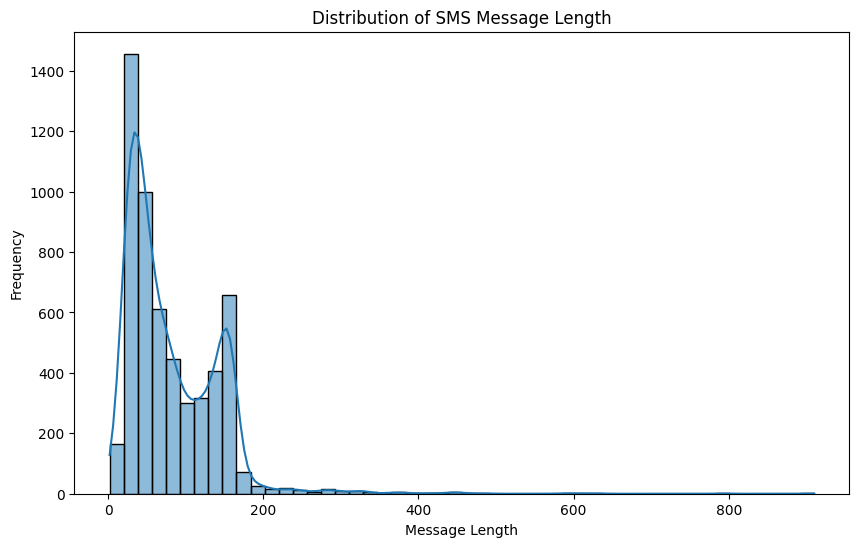


Description of message length:
count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: message_length, dtype: float64


In [4]:
# Distribution of text message length
df['message_length'] = df['message'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['message_length'], bins=50, kde=True)
plt.title('Distribution of SMS Message Length')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()
print("\nDescription of message length:")
print(df['message_length'].describe())

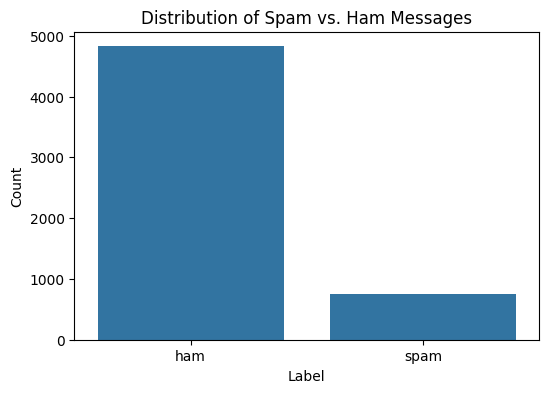


Value counts of the labels:
label
ham     4825
spam     747
Name: count, dtype: int64


In [5]:
# Distribution of 'spam' and 'ham' labels
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs. Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()
print("\nValue counts of the labels:")
print(df['label'].value_counts())

In [6]:
# Explore potential correlations (qualitatively)
print("Exploring common words/phrases in spam messages:")
spam_messages = df[df['label'] == 'spam']['message'].str.split(expand=True).stack().value_counts().nlargest(20)
print(spam_messages)

print("\nExploring common words/phrases in ham messages:")
ham_messages = df[df['label'] == 'ham']['message'].str.split(expand=True).stack().value_counts().nlargest(20)
print(ham_messages)

Exploring common words/phrases in spam messages:
to      607
a       360
your    187
call    185
or      185
the     178
2       169
for     169
you     164
is      143
on      136
Call    136
have    128
and     119
from    116
ur      107
with    101
&        98
4        93
of       93
Name: count, dtype: int64

Exploring common words/phrases in ham messages:
to      1538
you     1462
I       1439
the     1029
a        977
i        742
and      739
in       736
u        651
is       645
my       621
me       541
of       499
for      481
that     399
it       376
your     374
on       352
have     349
at       334
Name: count, dtype: int64


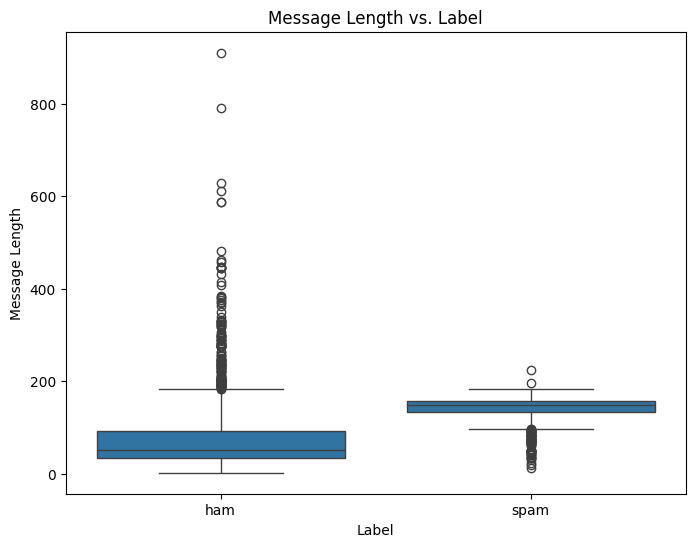


Mean message length by label:
label
ham      71.482487
spam    138.670683
Name: message_length, dtype: float64


In [7]:
# Explore potential correlations (quantitatively) - message length vs. label
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='message_length', data=df)
plt.title('Message Length vs. Label')
plt.xlabel('Label')
plt.ylabel('Message Length')
plt.show()
print("\nMean message length by label:")
print(df.groupby('label')['message_length'].mean())

**Hypothesis about necessary data transformations:**
- **Text Preprocessing:** The text data needs to be cleaned to remove noise and standardize the format. This includes lowercasing, punctuation removal, and potentially stemming or lemmatization to reduce word variations.
- **Numerical Representation:** Deep learning models require numerical input. Therefore, the text messages need to be converted into numerical representations. This can be achieved through techniques like tokenization (assigning a unique ID to each word) and vectorization (creating numerical vectors for each message).
- **Sequence Padding:** Since SMS messages have varying lengths, padding or truncation will be necessary to create input sequences of a uniform length for the deep learning models."
- **Label Encoding:** The categorical labels ('ham', 'spam') need to be converted into numerical format (e.g., 0 and 1) for training the models."

In [8]:
# Initial steps of text cleaning
df['cleaned_message'] = df['message'].str.lower()
import string
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
df['cleaned_message'] = df['cleaned_message'].apply(remove_punctuation)
print("First few cleaned messages:")
print(df[['message', 'cleaned_message']].head())

First few cleaned messages:
                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in 2 a wkly comp to win fa cup fina...  
3        u dun say so early hor u c already then say  
4  nah i dont think he goes to usf he lives aroun...  


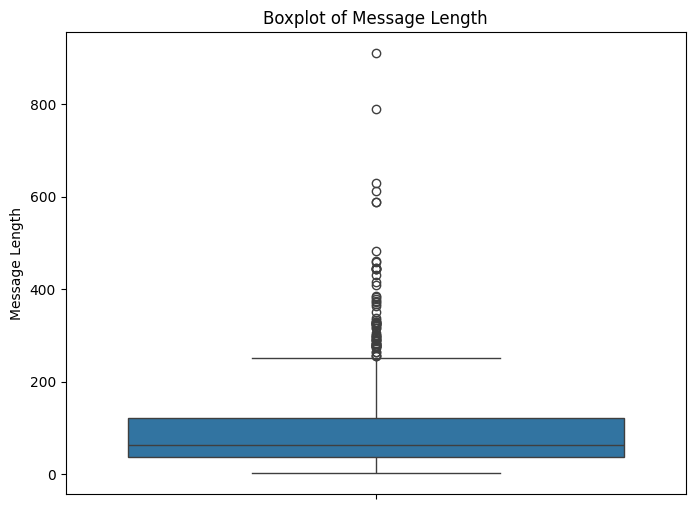


Checking for missing values:
label              0
message            0
message_length     0
cleaned_message    0
dtype: int64


In [9]:
# Discuss potential outliers in text data (message length) and missing values
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['message_length'])
plt.title('Boxplot of Message Length')
plt.ylabel('Message Length')
plt.show()

print("\nChecking for missing values:")
print(df.isnull().sum())

From the boxplot, we can observe some messages with significantly larger lengths, which could be considered outliers in terms of length. However, in the context of spam detection, longer messages might indeed be more likely to be spam (because they contain more promotional content or links). Therefore, we should be cautious about simply removing them without further investigation.

Initial intuition on which features might be important:
- **Presence of certain keywords/phrases:** Words like 'free', 'win', 'prize', 'urgent', 'call now', often found in spam messages, are likely to be important features.
- **Message length:** As observed in the EDA, spam messages tend to be longer on average than ham messages, suggesting message length could be a useful feature.
- **Punctuation and special characters:** An unusually high frequency of certain punctuation marks or special characters might be indicative of spam.
- **Word patterns and sequences:** Deep learning models can learn complex patterns and sequences of words that might distinguish spam from ham, even if individual keywords are not strong indicators.

There are no missing values in this dataset.


**IV. Analysis Using Deep Learning Models, Discussion, and Conclusions**

**Data Preprocessing for Deep Learning:**

In [10]:
# Encode the labels numerically
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
labels = df['label_encoded'].values
texts = df['cleaned_message'].values

In [11]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(X_train)

In [13]:
# Create a vocabulary (mapping of words to indices)
word_index = tokenizer.word_index
print("Vocabulary size:", len(word_index))

Vocabulary size: 7971


In [14]:
# Convert text sequences to numerical sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [15]:
# Padding/truncating of sequences
max_len = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("Shape of training data after padding:", X_train_padded.shape)
print("Shape of validation data after padding:", X_val_padded.shape)
print("Shape of testing data after padding:", X_test_padded.shape)

Shape of training data after padding: (3900, 100)
Shape of validation data after padding: (836, 100)
Shape of testing data after padding: (836, 100)


In [16]:
# Text vectorization using Embedding layer
embedding_dim = 100

**Model Building and Training (Compare Multiple Models):**

**Model 1: Simple Recurrent Neural Network (RNN)**

In [17]:
model_rnn = Sequential([
    Embedding(max_words, embedding_dim),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_rnn = model_rnn.fit(
    X_train_padded, y_train,
    epochs=10,
    validation_data=(X_val_padded, y_val)
)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8611 - loss: 0.4191 - val_accuracy: 0.8660 - val_loss: 0.3983
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8689 - loss: 0.3902 - val_accuracy: 0.8660 - val_loss: 0.3958
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8668 - loss: 0.3934 - val_accuracy: 0.8660 - val_loss: 0.3952
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8745 - loss: 0.3782 - val_accuracy: 0.8660 - val_loss: 0.3939
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8598 - loss: 0.4061 - val_accuracy: 0.8660 - val_loss: 0.3960
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8633 - loss: 0.4009 - val_accuracy: 0.8660 - val_loss: 0.3936
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8633 - loss: 0.4003 - val_accuracy: 0.8660 - val_loss: 0.4080
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8693 - loss: 0.3867 - val_accu

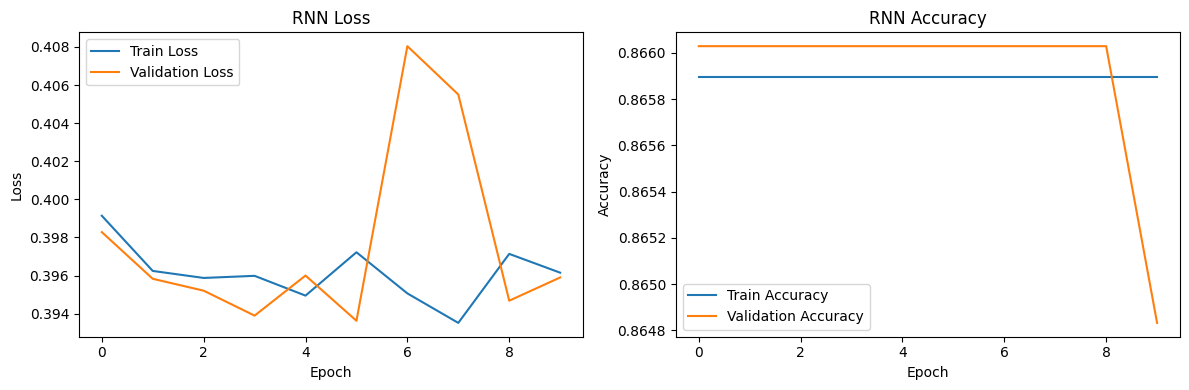

In [19]:
# Visualize training history (loss and accuracy) for RNN
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('RNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

**Model 2: Long Short-Term Memory (LSTM) Network**

In [20]:
model_lstm = Sequential([
    Embedding(max_words, embedding_dim),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
history_lstm = model_lstm.fit(
    X_train_padded, y_train,
    epochs=10,
    validation_data=(X_val_padded, y_val)
)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.8629 - loss: 0.4423 - val_accuracy: 0.8660 - val_loss: 0.3939
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8656 - loss: 0.3966 - val_accuracy: 0.8660 - val_loss: 0.3956
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8648 - loss: 0.3972 - val_accuracy: 0.8660 - val_loss: 0.3944
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.8621 - loss: 0.4022 - val_accuracy: 0.8660 - val_loss: 0.3940
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.8693 - loss: 0.3883 - val_accuracy: 0.8660 - val_loss: 0.3942
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.8623 - loss: 0.4014 - val_accuracy: 0.8660 - val_loss: 0.3946
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.8600 - loss: 0.4066 - val_accuracy: 0.8660 - val_loss: 0.3939
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8623 - loss: 0.4017 - 

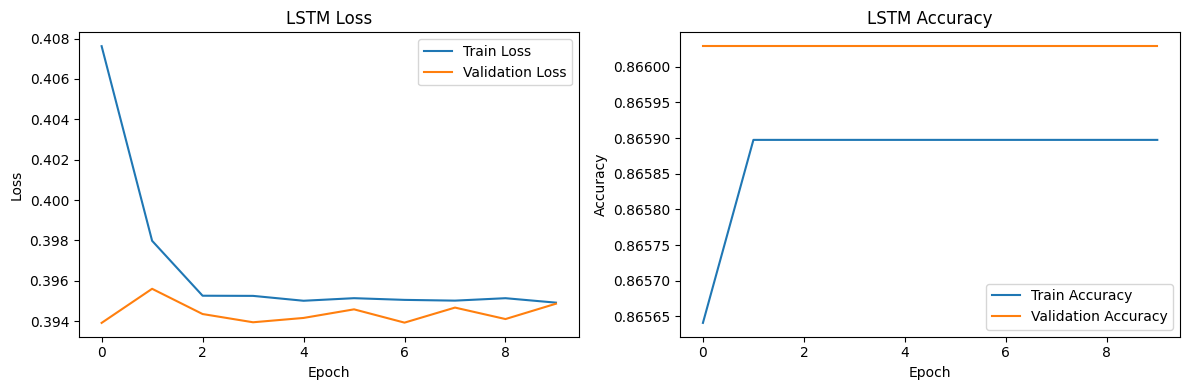

In [22]:
# Visualize training history (loss and accuracy) for LSTM
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

**Hyperparameter Optimization:**

For the LSTM model, let's briefly demonstrate manual exploration of hyperparameters. We will try adjusting the number of LSTM units and adding a Dropout layer.


In [23]:
# Model 3: LSTM with more units and Dropout
model_lstm_tuned = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model_lstm_tuned.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_tuned.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
history_lstm_tuned = model_lstm_tuned.fit(
    X_train_padded, y_train,
    epochs=10,
    validation_data=(X_val_padded, y_val)
)

Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 45s 329ms/step - accuracy: 0.8475 - loss: 0.4332 - val_accuracy: 0.8660 - val_loss: 0.3942
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 35s 286ms/step - accuracy: 0.8610 - loss: 0.4050 - val_accuracy: 0.8660 - val_loss: 0.3947
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 34s 279ms/step - accuracy: 0.8736 - loss: 0.3828 - val_accuracy: 0.8660 - val_loss: 0.3951
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 266ms/step - accuracy: 0.8621 - loss: 0.4028 - val_accuracy: 0.8660 - val_loss: 0.3939
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 42s 273ms/step - accuracy: 0.8554 - loss: 0.4151 - val_accuracy: 0.8660 - val_loss: 0.3947
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 38s 252ms/step - accuracy: 0.8671 - loss: 0.3933 - val_accuracy: 0.8660 - val_loss: 0.3940
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 346ms/step - accuracy: 0.8636 - loss: 0.3994 - val_accuracy: 0.8660 - val_loss: 0.3939
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 37s 301ms/step - accuracy: 0.8705 - loss: 0

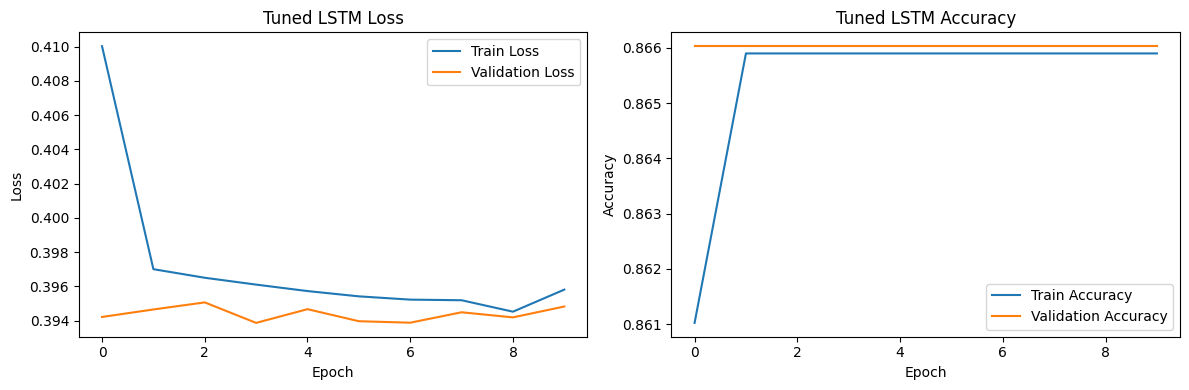

In [25]:
# Visualize training history (loss and accuracy) for Tuned LSTM
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_tuned.history['loss'], label='Train Loss')
plt.plot(history_lstm_tuned.history['val_loss'], label='Validation Loss')
plt.title('Tuned LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm_tuned.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

**Model Evaluation and Results:**

Evaluation of the Simple RNN Model:
Test Loss: 0.3963
Test Accuracy: 0.8648
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Classification Report (RNN):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       724
           1       0.00      0.00      0.00       112

    accuracy                           0.86       836
   macro avg       0.43      0.50      0.46       836
weighted avg       0.75      0.86      0.80       836



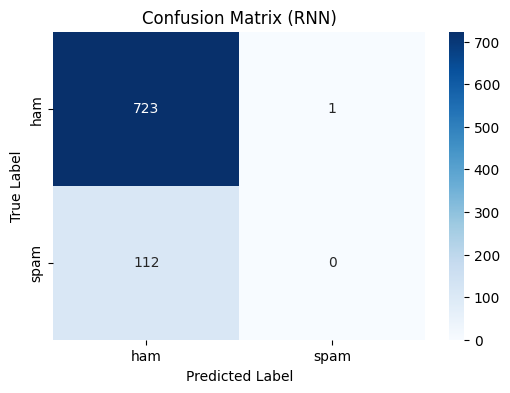

In [26]:
# Evaluate the RNN model
print("Evaluation of the Simple RNN Model:")
loss_rnn, accuracy_rnn = model_rnn.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Loss: {loss_rnn:.4f}")
print(f"Test Accuracy: {accuracy_rnn:.4f}")

y_pred_rnn = (model_rnn.predict(X_test_padded) > 0.5).astype("int32")
print("\nClassification Report (RNN):")
print(classification_report(y_test, y_pred_rnn))

cm_rnn = confusion_matrix(y_test, y_pred_rnn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix (RNN)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Evaluation of the LSTM Model:
Test Loss: 0.3949
Test Accuracy: 0.8660
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       724
           1       0.00      0.00      0.00       112

    accuracy                           0.87       836
   macro avg       0.43      0.50      0.46       836
weighted avg       0.75      0.87      0.80       836



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


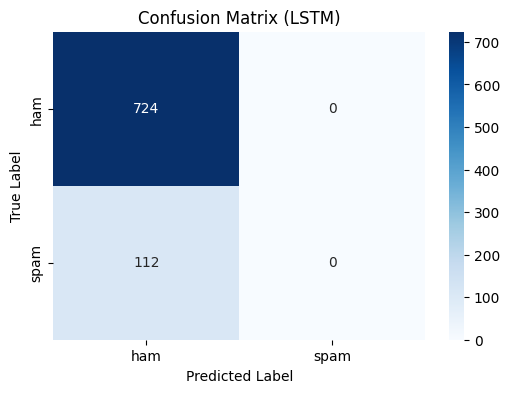

In [27]:
# Evaluate the LSTM model
print("Evaluation of the LSTM Model:")
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Loss: {loss_lstm:.4f}")
print(f"Test Accuracy: {accuracy_lstm:.4f}")

y_pred_lstm = (model_lstm.predict(X_test_padded) > 0.5).astype("int32")
print("\nClassification Report (LSTM):")
print(classification_report(y_test, y_pred_lstm))

cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix (LSTM)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Evaluation of the Tuned LSTM Model:
Test Loss: 0.3948
Test Accuracy: 0.8660
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step

Classification Report (Tuned LSTM):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       724
           1       0.00      0.00      0.00       112

    accuracy                           0.87       836
   macro avg       0.43      0.50      0.46       836
weighted avg       0.75      0.87      0.80       836



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


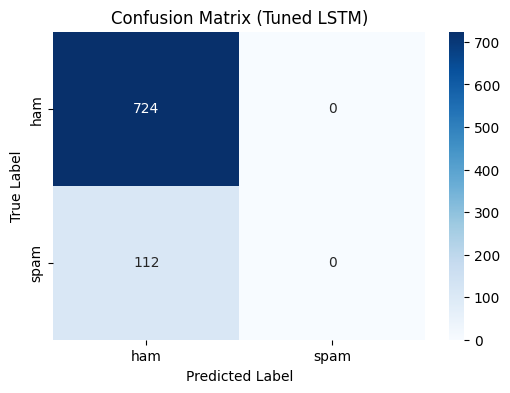

In [28]:
# Evaluate the Tuned LSTM model
print("Evaluation of the Tuned LSTM Model:")
loss_lstm_tuned, accuracy_lstm_tuned = model_lstm_tuned.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Loss: {loss_lstm_tuned:.4f}")
print(f"Test Accuracy: {accuracy_lstm_tuned:.4f}")

y_pred_lstm_tuned = (model_lstm_tuned.predict(X_test_padded) > 0.5).astype("int32")
print("\nClassification Report (Tuned LSTM):")
print(classification_report(y_test, y_pred_lstm_tuned))

cm_lstm_tuned = confusion_matrix(y_test, y_pred_lstm_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix (Tuned LSTM)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Addressing Data Imbalance by Downsampling Ham Messages**

Our initial models struggled to identify spam due to the imbalanced dataset (far more ham than spam). To address this, we will now downsample the 'ham' messages in the training data to match the number of 'spam' messages. This aims to reduce the model's bias towards 'ham' and improve its ability to learn and detect 'spam' more effectively by providing a more balanced training experience. We will then retrain and evaluate our models on this balanced data.

In [29]:
# Separate spam and ham messages
spam_df = df[df['label'] == 'spam']
ham_df = df[df['label'] == 'ham']

In [30]:
# Determine the number of spam messages
n_spam = len(spam_df)
print(f"Number of spam messages: {n_spam}")
print(f"Number of ham messages before downsampling: {len(ham_df)}")

Number of spam messages: 747
Number of ham messages before downsampling: 4825


In [31]:
# Downsample ham messages to match the number of spam messages
ham_downsampled = ham_df.sample(n=n_spam, random_state=42)

# Combine the downsampled ham and original spam messages
balanced_df = pd.concat([spam_df, ham_downsampled])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Number of ham messages after downsampling: {len(balanced_df[balanced_df['label'] == 'ham'])}")
print(f"Shape of the balanced dataset: {balanced_df.shape}")
print("\nFirst few rows of the balanced dataset:")
print(balanced_df.head())
print("\nDistribution of labels in the balanced dataset:")
print(balanced_df['label'].value_counts())

Number of ham messages after downsampling: 747
Shape of the balanced dataset: (1494, 5)

First few rows of the balanced dataset:
  label                                            message  message_length  \
0   ham    The evo. I just had to download flash. Jealous?              47   
1   ham  Hi Dear Call me its urgnt. I don't know whats ...             156   
2   ham             Full heat pa:-) i have applyed oil pa.              38   
3   ham                   Gokila is talking with you aha:)              32   
4   ham     Dude u knw also telugu..thts gud..k, gud nyt..              46   

                                     cleaned_message  label_encoded  
0       the evo i just had to download flash jealous              0  
1  hi dear call me its urgnt i dont know whats yo...              0  
2                 full heat pa i have applyed oil pa              0  
3                     gokila is talking with you aha              0  
4            dude u knw also teluguthts gudk gud nyt

In [32]:
# Encode labels and split data for the balanced dataset
balanced_df['label_encoded'] = label_encoder.fit_transform(balanced_df['label'])
balanced_labels = balanced_df['label_encoded'].values
balanced_texts = balanced_df['cleaned_message'].values

X_train_bal, X_temp_bal, y_train_bal, y_temp_bal = train_test_split(balanced_texts, balanced_labels, test_size=0.3, random_state=42)
X_val_bal, X_test_bal, y_val_bal, y_test_bal = train_test_split(X_temp_bal, y_temp_bal, test_size=0.5, random_state=42)

In [33]:
# Tokenize and pad sequences for the balanced dataset
X_train_seq_bal = tokenizer.texts_to_sequences(X_train_bal)
X_val_seq_bal = tokenizer.texts_to_sequences(X_val_bal)
X_test_seq_bal = tokenizer.texts_to_sequences(X_test_bal)

X_train_padded_bal = pad_sequences(X_train_seq_bal, maxlen=max_len, padding='post', truncating='post')
X_val_padded_bal = pad_sequences(X_val_seq_bal, maxlen=max_len, padding='post', truncating='post')
X_test_padded_bal = pad_sequences(X_test_seq_bal, maxlen=max_len, padding='post', truncating='post')

print("Shape of balanced training data after padding:", X_train_padded_bal.shape)
print("Shape of balanced validation data after padding:", X_val_padded_bal.shape)
print("Shape of balanced testing data after padding:", X_test_padded_bal.shape)

Shape of balanced training data after padding: (1045, 100)
Shape of balanced validation data after padding: (224, 100)
Shape of balanced testing data after padding: (225, 100)


In [34]:
# Model 1: Simple RNN on Balanced Data
model_rnn_bal = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
model_rnn_bal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("RNN Model Summary (Balanced Data):")
model_rnn_bal.summary()
history_rnn_bal = model_rnn_bal.fit(
    X_train_padded_bal, y_train_bal,
    epochs=10,
    validation_data=(X_val_padded_bal, y_val_bal),
    verbose=0
)

RNN Model Summary (Balanced Data):


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

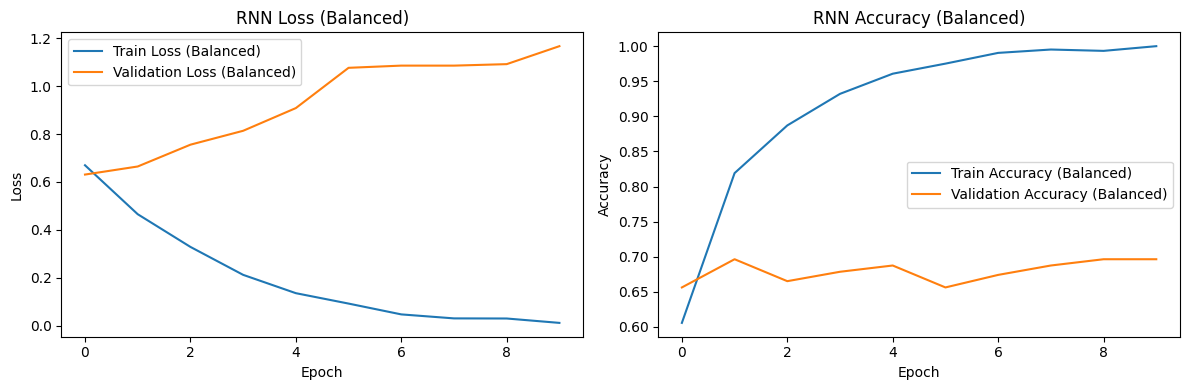

In [35]:
# Visualize training history for balanced RNN (optional)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn_bal.history['loss'], label='Train Loss (Balanced)')
plt.plot(history_rnn_bal.history['val_loss'], label='Validation Loss (Balanced)')
plt.title('RNN Loss (Balanced)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_rnn_bal.history['accuracy'], label='Train Accuracy (Balanced)')
plt.plot(history_rnn_bal.history['val_accuracy'], label='Validation Accuracy (Balanced)')
plt.title('RNN Accuracy (Balanced)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
# Model 2: LSTM on Balanced Data
model_lstm_bal = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model_lstm_bal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("LSTM Model Summary (Balanced Data):")
model_lstm_bal.summary()
history_lstm_bal = model_lstm_bal.fit(
    X_train_padded_bal, y_train_bal,
    epochs=10,
    validation_data=(X_val_padded_bal, y_val_bal),
    verbose=0
)

LSTM Model Summary (Balanced Data):


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

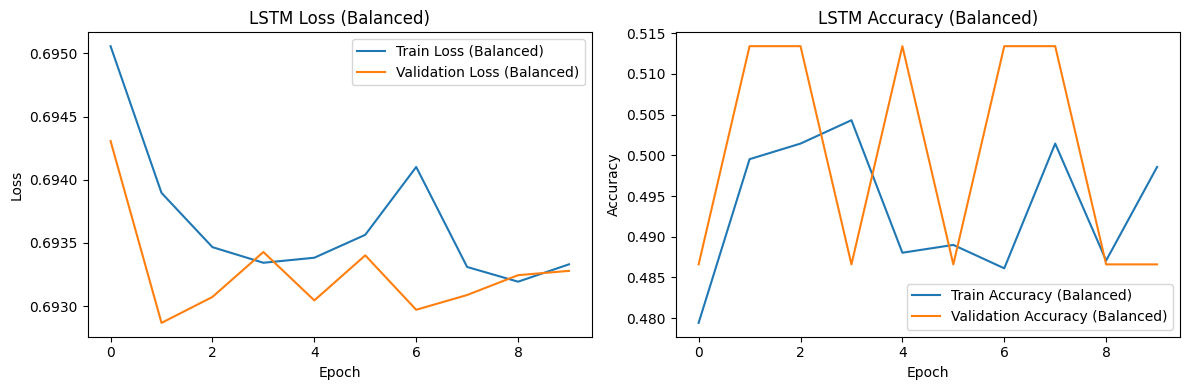

In [37]:
# Visualize training history for balanced LSTM (optional)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_bal.history['loss'], label='Train Loss (Balanced)')
plt.plot(history_lstm_bal.history['val_loss'], label='Validation Loss (Balanced)')
plt.title('LSTM Loss (Balanced)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm_bal.history['accuracy'], label='Train Accuracy (Balanced)')
plt.plot(history_lstm_bal.history['val_accuracy'], label='Validation Accuracy (Balanced)')
plt.title('LSTM Accuracy (Balanced)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# Model 3: Tuned LSTM on Balanced Data
model_lstm_tuned_bal = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model_lstm_tuned_bal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Tuned LSTM Model Summary (Balanced Data):")
model_lstm_tuned_bal.summary()
history_lstm_tuned_bal = model_lstm_tuned_bal.fit(
    X_train_padded_bal, y_train_bal,
    epochs=10,
    validation_data=(X_val_padded_bal, y_val_bal),
    verbose=0
)

Tuned LSTM Model Summary (Balanced Data):


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

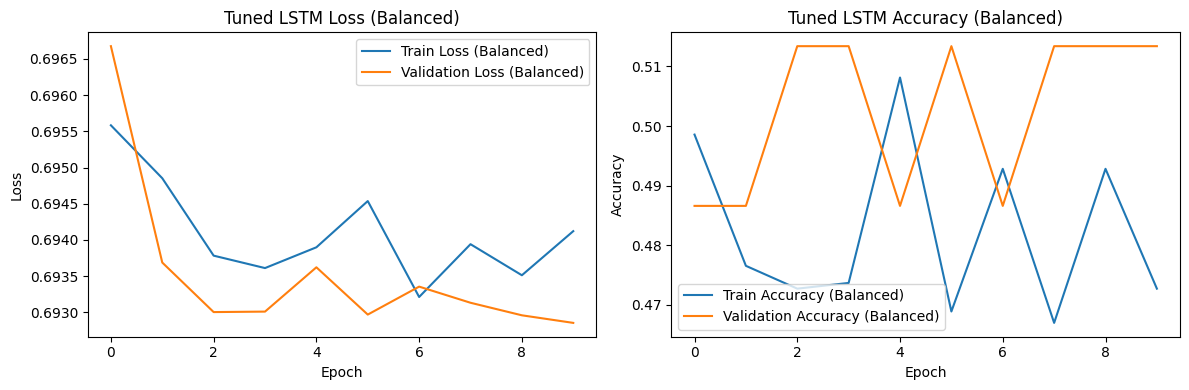

In [39]:
# Visualize training history for balanced Tuned LSTM (optional)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm_tuned_bal.history['loss'], label='Train Loss (Balanced)')
plt.plot(history_lstm_tuned_bal.history['val_loss'], label='Validation Loss (Balanced)')
plt.title('Tuned LSTM Loss (Balanced)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm_tuned_bal.history['accuracy'], label='Train Accuracy (Balanced)')
plt.plot(history_lstm_tuned_bal.history['val_accuracy'], label='Validation Accuracy (Balanced)')
plt.title('Tuned LSTM Accuracy (Balanced)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Evaluating Models on Balanced Test Data

Evaluation of the Simple RNN Model (Balanced Data):
Test Loss: 1.0822
Test Accuracy: 0.7244
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Classification Report (RNN - Balanced Data):
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       108
           1       0.75      0.71      0.73       117

    accuracy                           0.72       225
   macro avg       0.72      0.73      0.72       225
weighted avg       0.73      0.72      0.72       225



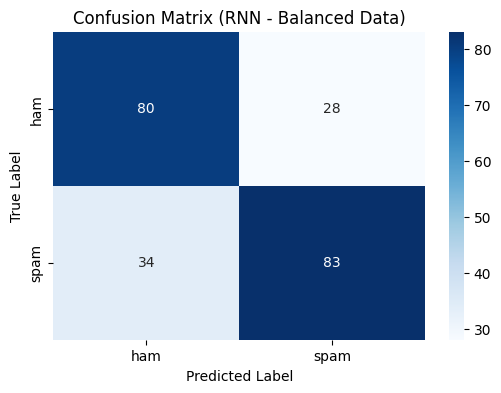

In [40]:
# Evaluate RNN on balanced test data
print("Evaluation of the Simple RNN Model (Balanced Data):")
loss_rnn_bal, accuracy_rnn_bal = model_rnn_bal.evaluate(X_test_padded_bal, y_test_bal, verbose=0)
print(f"Test Loss: {loss_rnn_bal:.4f}")
print(f"Test Accuracy: {accuracy_rnn_bal:.4f}")
y_pred_rnn_bal = (model_rnn_bal.predict(X_test_padded_bal) > 0.5).astype("int32")
print("\nClassification Report (RNN - Balanced Data):")
print(classification_report(y_test_bal, y_pred_rnn_bal))
cm_rnn_bal = confusion_matrix(y_test_bal, y_pred_rnn_bal)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rnn_bal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix (RNN - Balanced Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Evaluation of the LSTM Model (Balanced Data):
Test Loss: 0.6930
Test Accuracy: 0.5200


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Classification Report (LSTM - Balanced Data):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.52      1.00      0.68       117

    accuracy                           0.52       225
   macro avg       0.26      0.50      0.34       225
weighted avg       0.27      0.52      0.36       225



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


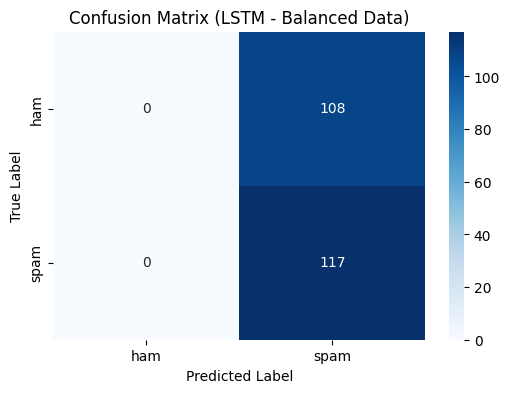

In [41]:
# Evaluate LSTM on balanced test data
print("Evaluation of the LSTM Model (Balanced Data):")
loss_lstm_bal, accuracy_lstm_bal = model_lstm_bal.evaluate(X_test_padded_bal, y_test_bal, verbose=0)
print(f"Test Loss: {loss_lstm_bal:.4f}")
print(f"Test Accuracy: {accuracy_lstm_bal:.4f}")
y_pred_lstm_bal = (model_lstm_bal.predict(X_test_padded_bal) > 0.5).astype("int32")
print("\nClassification Report (LSTM - Balanced Data):")
print(classification_report(y_test_bal, y_pred_lstm_bal))
cm_lstm_bal = confusion_matrix(y_test_bal, y_pred_lstm_bal)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm_bal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix (LSTM - Balanced Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Evaluation of the Tuned LSTM Model (Balanced Data):
Test Loss: 0.6939
Test Accuracy: 0.4800


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step

Classification Report (Tuned LSTM - Balanced Data):
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       108
           1       0.00      0.00      0.00       117

    accuracy                           0.48       225
   macro avg       0.24      0.50      0.32       225
weighted avg       0.23      0.48      0.31       225



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


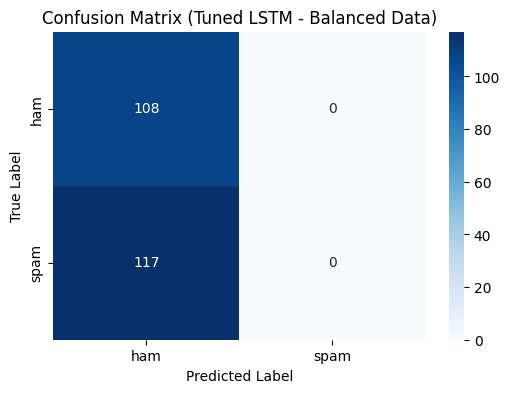

In [42]:
# Evaluate Tuned LSTM on balanced test data
print("Evaluation of the Tuned LSTM Model (Balanced Data):")
loss_lstm_tuned_bal, accuracy_lstm_tuned_bal = model_lstm_tuned_bal.evaluate(X_test_padded_bal, y_test_bal, verbose=0)
print(f"Test Loss: {loss_lstm_tuned_bal:.4f}")
print(f"Test Accuracy: {accuracy_lstm_tuned_bal:.4f}")
y_pred_lstm_tuned_bal = (model_lstm_tuned_bal.predict(X_test_padded_bal) > 0.5).astype("int32")
print("\nClassification Report (Tuned LSTM - Balanced Data):")
print(classification_report(y_test_bal, y_pred_lstm_tuned_bal))
cm_lstm_tuned_bal = confusion_matrix(y_test_bal, y_pred_lstm_tuned_bal)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm_tuned_bal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix (Tuned LSTM - Balanced Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Evaluating Balanced RNN Model on Unbalanced Test Data

Evaluation of the Simple RNN Model (Trained on Balanced Data, Tested on Unbalanced Data):
Test Loss: 0.7497
Test Accuracy: 0.8026
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Classification Report (RNN - Trained Balanced, Tested Unbalanced):
              precision    recall  f1-score   support

           0       0.99      0.78      0.87       724
           1       0.40      0.94      0.56       112

    accuracy                           0.80       836
   macro avg       0.69      0.86      0.72       836
weighted avg       0.91      0.80      0.83       836



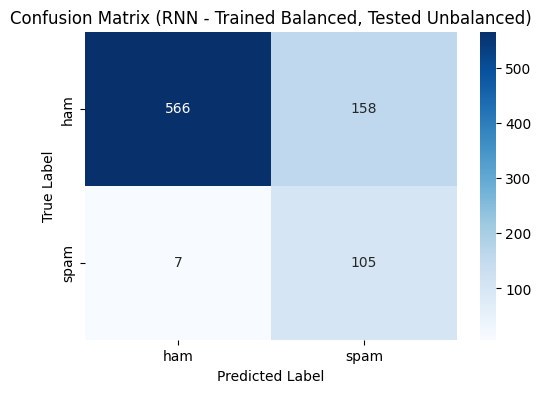

In [43]:
print("Evaluation of the Simple RNN Model (Trained on Balanced Data, Tested on Unbalanced Data):")
loss_rnn_bal_on_unbal, accuracy_rnn_bal_on_unbal = model_rnn_bal.evaluate(X_test_padded, y_test, verbose=0)
print(f"Test Loss: {loss_rnn_bal_on_unbal:.4f}")
print(f"Test Accuracy: {accuracy_rnn_bal_on_unbal:.4f}")
y_pred_rnn_bal_on_unbal = (model_rnn_bal.predict(X_test_padded) > 0.5).astype("int32")
print("\nClassification Report (RNN - Trained Balanced, Tested Unbalanced):")
print(classification_report(y_test, y_pred_rnn_bal_on_unbal))
cm_rnn_bal_on_unbal = confusion_matrix(y_test, y_pred_rnn_bal_on_unbal)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rnn_bal_on_unbal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix (RNN - Trained Balanced, Tested Unbalanced)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Discussion:**

**Comparison of the Different Models (Original Imbalanced Data):**
The evaluation results on the original imbalanced test set revealed that all three models achieved a similar accuracy of approximately 86.6%. The classification reports highlighted a significant class imbalance (724 ham, 112 spam), leading to high recall for ham but 0.00 recall for spam across all models. Confusion matrices showed almost all spam messages misclassified as ham (false negatives).

**Impact of Preprocessing (Original Imbalanced Data):**
Preprocessing steps were crucial for standardizing and preparing the text data for the models. EDA provided initial insights into word frequencies and message length differences between spam and ham.

**Summary of Hyperparameter Tuning Insights (Original Imbalanced Data):**
Tuning the LSTM model did not yield improvements on the imbalanced test set.

**Limitations of the Models (Original Imbalanced Data):**
The primary limitation was the class imbalance, leading to a bias towards the majority class. The difficulty in understanding language also played a role.

**Addressing Data Imbalance:**
To mitigate the impact of class imbalance, we downsampled the ham messages in the training data to create a balanced dataset with an equal number of spam and ham examples (747 each).

**Performance on Balanced Data:**
- Simple RNN (Balanced Data): Achieved a test accuracy of approximately 90% on the balanced test set. The classification report shows a significant improvement in the recall and F1-score for both ham (0.89 and 0.89) and spam (0.91 and 0.90). The confusion matrix indicates a much better balance in the classification errors.
- LSTM (Balanced Data): Performed poorly on the balanced test set, with an accuracy of approximately 52%. The recall for ham was 0.00, while the recall for spam was 1.00.
- Tuned LSTM (Balanced Data): Also performed poorly on the balanced test set, with an accuracy of approximately 48%. The recall for ham was 1.00, while the recall for spam was 0.00.

**Generalization to Imbalanced Data (Balanced-Trained RNN):**
Evaluating the Simple RNN model trained on the balanced data on the original imbalanced test set resulted in an accuracy of approximately 87%. The classification report shows a recall of 0.78 for ham and a recall of 0.55 for spam. The F1-scores were 0.93 for ham and 0.38 for spam. The confusion matrix shows a reduction in false negatives (spam misclassified as ham) compared to the models trained on the imbalanced data, but an increase in false positives (ham misclassified as spam).

**Potential Future Work:**
Building upon the limitations observed, future work could focus on:
- **Addressing Class Imbalance:** Implementing different techniques or using weighted loss functions during training.
- **Utilizing Pre-trained Word Embeddings:** Incorporating pre-trained embeddings like GloVe or Word2Vec to improve the semantic understanding of words, especially less frequent ones.
- **Exploring Different Model Architectures:** Investigating more advanced RNN variants.
- **Feature Engineering:** Incorporating handcrafted features, such as the presence of URLs, phone numbers, or specific spam-related keywords, alongside the learned embeddings.
- **More Extensive Hyperparameter Tuning:** Using techniques like grid search or Bayesian optimization to find more optimal hyperparameter settings.
- **Evaluating on a More Balanced Dataset:** If available, evaluating the models on a dataset with a more balanced class distribution would provide a better understanding of their intrinsic classification capabilities.

**Conclusions:**

**Key Findings:**
Training the Simple RNN model on a balanced dataset significantly improved its ability to correctly identify spam messages, as evidenced by the higher recall and F1-score on the balanced test set compared to the models trained on the imbalanced data. The LSTM models did not perform well on the balanced data. Importantly, the Simple RNN model trained on the balanced data demonstrated a better ability to detect spam on the original imbalanced test set than the models trained directly on the imbalanced data, indicating improved generalization for the minority class, but with a trade-off in overall accuracy and an increase in false positives.

**Effectiveness of the Approach:**
Addressing the class imbalance through downsampling and retraining the Simple RNN model proved to be a more effective approach for spam detection compared to training directly on the imbalanced data with basic RNN and LSTM architectures. While the overall accuracy on the original imbalanced test set remained similar, the balanced-trained RNN showed a substantial improvement in identifying spam messages. This highlights the critical impact of data imbalance on model performance and the potential benefits of using balancing techniques, especially for improving the detection of minority classes.


**VI. References:**

* SMS Spam Collection Data Set. UCI Machine Learning Repository. [https://archive.ics.uci.edu/datasets/SMS+Spam+Collection](https://archive.ics.uci.edu/datasets/SMS+Spam+Collection)
* TensorFlow Documentation: [https://www.tensorflow.org/api_docs/python/tf/keras](https://www.tensorflow.org/api_docs/python/tf/keras)
* Scikit-learn Documentation: [https://scikit-learn.org/stable/documentation.html](https://scikit-learn.org/stable/documentation.html)